# Objective Evaluations - Scores

In [ ]:
import pandas as pd
from scipy.stats import f_oneway

In [ ]:
resp_data = pd.read_csv('questionnaire\\long_term\\response_summary_long.csv')
resp_data.head(5)

## Mix-up

In [ ]:
# Group by 'method' and compute mean and std of 'score'
grouped_data = resp_data.groupby('method')['score'].agg(['mean', 'std'])

# Perform ANOVA test
anova_result = f_oneway(*[group['score'] for name, group in resp_data.groupby('method')])

# Print the mean and std of 'score' for each 'method'
print("Mean and Standard Deviation of 'score' by 'method':")
print(grouped_data)

# Print the ANOVA test result
print("\nANOVA Test Result:")
print("F-value:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

## Add strategy

In [ ]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='strategy', y='score', hue='method', data=resp_data, palette='viridis')

# Set plot title and labels
plt.title('Scores by Strategy and Method')
plt.xlabel('Strategy')
plt.ylabel('Score')

# Display the plot
plt.show()

## Shirley's Method

for each participant {
    baseline_score_g = mean(method==0, G);
    baseline_score_o = mean(method==0, O);
    for each passage whose method == 1 {
        do pair t-test between the score (compare the score and the corresponding baseline, decided by G or O)
    }
}

## Add overall recall and theme recall

recall: overall recall

theme: the question 6

overall: the total score

In [ ]:
import pandas as pd
from scipy.stats import ttest_rel

# Step 1: Load the data and split by method
df = pd.read_csv('questionnaire/long_term/response_summary_long.csv')

# Split into two dataframes based on method
df_method_0 = df[df['method'] == 0]
df_method_1 = df[df['method'] == 1]

# Function to compute baseline scores
def compute_baseline(df_method_0, column_name):
    baseline_scores = df_method_0.groupby(['participant', 'corpus'])[column_name].mean().reset_index()
    baseline_scores.rename(columns={column_name: f'baseline_{column_name}'}, inplace=True)
    return baseline_scores

# Compute baseline scores for 'score', 'recall', and 'theme'
baseline_score = compute_baseline(df_method_0, 'score')
baseline_recall = compute_baseline(df_method_0, 'recall')
baseline_theme = compute_baseline(df_method_0, 'theme')
baseline_overall = compute_baseline(df_method_0, 'overall')

# Merge the baseline scores with method==1 dataframe
df_method_1_merged = pd.merge(df_method_1, baseline_score, on=['participant', 'corpus'])
df_method_1_merged = pd.merge(df_method_1_merged, baseline_recall, on=['participant', 'corpus'])
df_method_1_merged = pd.merge(df_method_1_merged, baseline_theme, on=['participant', 'corpus'])
df_method_1_merged = pd.merge(df_method_1_merged, baseline_overall, on=['participant', 'corpus'])

# Function to perform t-test and print results
def perform_t_test(df_method_1_merged, column_name):
    t_stat, p_value = ttest_rel(df_method_1_merged[column_name], df_method_1_merged[f'baseline_{column_name}'])
    average_score_method_0 = df_method_0[column_name].mean()
    average_score_method_1 = df_method_1_merged[column_name].mean()
    print(f"Average {column_name} for method 0:", average_score_method_0)
    print(f"Average {column_name} for method 1:", average_score_method_1)
    print(f"T-statistic for {column_name}:", t_stat)
    print(f"P-value for {column_name}:", p_value)
    print('\n')

# Perform t-tests for 'score', 'recall', and 'theme'
for column in ['score', 'recall', 'theme', 'overall']:
    perform_t_test(df_method_1_merged, column)

# Save the merged dataframe with baseline columns to a single CSV file
df_method_1_merged.to_csv('questionnaire/long_term/t-test_results.csv', index=False)



# Initialize a list to store the results
results = []

# Function to perform t-test and store results
def perform_t_test_by_corpus(df_method_1_merged, column_name):
    grouped = df_method_1_merged.groupby('corpus')
    for corpus_name, group in grouped:
        t_stat, p_value = ttest_rel(group[column_name], group[f'baseline_{column_name}'])
        average_score_method_0 = df_method_0[df_method_0['corpus'] == corpus_name][column_name].mean()
        average_score_method_1 = group[column_name].mean()
        
        # Store the results in the list
        results.append({
            'corpus': corpus_name,
            'metric': column_name,
            'average_method_0': average_score_method_0,
            'average_method_1': average_score_method_1,
            't_statistic': t_stat,
            'p_value': p_value
        })

# Perform t-tests for 'score', 'recall', 'theme', and 'overall' grouped by corpus
for column in ['score', 'recall', 'theme', 'overall']:
    perform_t_test_by_corpus(df_method_1_merged, column)

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Output the results DataFrame
print(results_df)


## Visualization and P value calculation for each strategy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import json

# Load the uploaded CSV data
file_path = 'questionnaire/long_term/response_summary_long.csv'
data = pd.read_csv(file_path)

# Extract unique strategies
strategies = data['strategy'].unique()

# Initialize dictionary to store results
results = {}

# Iterate over each strategy and column of interest
for strategy in strategies:
    strategy_data = data[data['strategy'] == strategy]
    results[strategy] = {}
    
    for column in ['score', 'recall', 'theme', 'overall']:
        results[strategy][column] = {}
        
        # Prepare data for ANOVA
        method_groups = [strategy_data[strategy_data['method'] == method][column].values for method in strategy_data['method'].unique()]
        
        # Perform one-way ANOVA
        f_stat, p_value = stats.f_oneway(*method_groups)
        
        # Store results in dictionary
        results[strategy][column] = {
            'f_stat': f_stat,
            'p_value': p_value
        }
        
        # Plotting for each column
        fig, ax = plt.subplots(figsize=(12, 6))
        boxplot_data = method_groups
        labels = [f'Method {method}' for method in strategy_data['method'].unique()]
        
        ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
        plt.xlabel('Method')
        plt.ylabel(column.capitalize())
        plt.title(f'{column.capitalize()} Comparison within {strategy} (ANOVA)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Optionally, save the results to a JSON file
output_file = '/Users/fukexue/film_learning_study3/questionnaire/long_term/strategy_comparison_anova_results.json'
with open(output_file, 'w') as json_file:
    json.dump(results, json_file, indent=4)

# Print the results dictionary for review
print(json.dumps(results, indent=4))


## To test one way anova

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import json

# Load the uploaded CSV data
file_path = 'questionnaire/long_term/response_summary_long.csv'
data = pd.read_csv(file_path)

# Extract unique strategies
strategies = data['strategy'].unique()

# Initialize dictionary to store ANOVA results and means of method 0 and method 1
results = {}

# Prepare subplots for combined visualization
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
columns = ['score', 'recall', 'theme', 'overall']
axes = axs.flatten()

# Iterate over each column of interest
for i, column in enumerate(columns):
    combined_data = []
    labels = []
    
    results[column] = {}
    
    for strategy in strategies:
        strategy_data = data[data['strategy'] == strategy]
        
        method_0_data = strategy_data[strategy_data['method'] == 0][column].values
        method_1_data = strategy_data[strategy_data['method'] == 1][column].values
        
        # Calculate means for method 0 and method 1
        mean_0 = method_0_data.mean()
        mean_1 = method_1_data.mean()
        
        # Prepare data for ANOVA
        method_groups = [strategy_data[strategy_data['method'] == method][column].values for method in strategy_data['method'].unique()]
        
        # Perform one-way ANOVA
        f_stat, p_value = stats.f_oneway(*method_groups)
        
        # Store both means and ANOVA p-values in the results dictionary
        results[column][strategy] = {
            'method_0_mean': mean_0,
            'method_1_mean': mean_1,
            'f_stat': f_stat,
            'p_value': p_value
        }
        
        # Combine data for boxplot
        combined_data.append(method_0_data)
        combined_data.append(method_1_data)
        labels.append(f'{strategy} (Method 0)')
        labels.append(f'{strategy} (Method 1)')
    
    # Plotting combined boxplot for each column
    axes[i].boxplot(combined_data, labels=labels, patch_artist=True)
    axes[i].set_title(f'{column.capitalize()} across all Strategies')
    axes[i].set_xlabel('Strategy and Method')
    axes[i].set_ylabel(column.capitalize())
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display the combined results dictionary with means and ANOVA results
print(json.dumps(results, indent=4))


##  to test repeated measures ANOVA

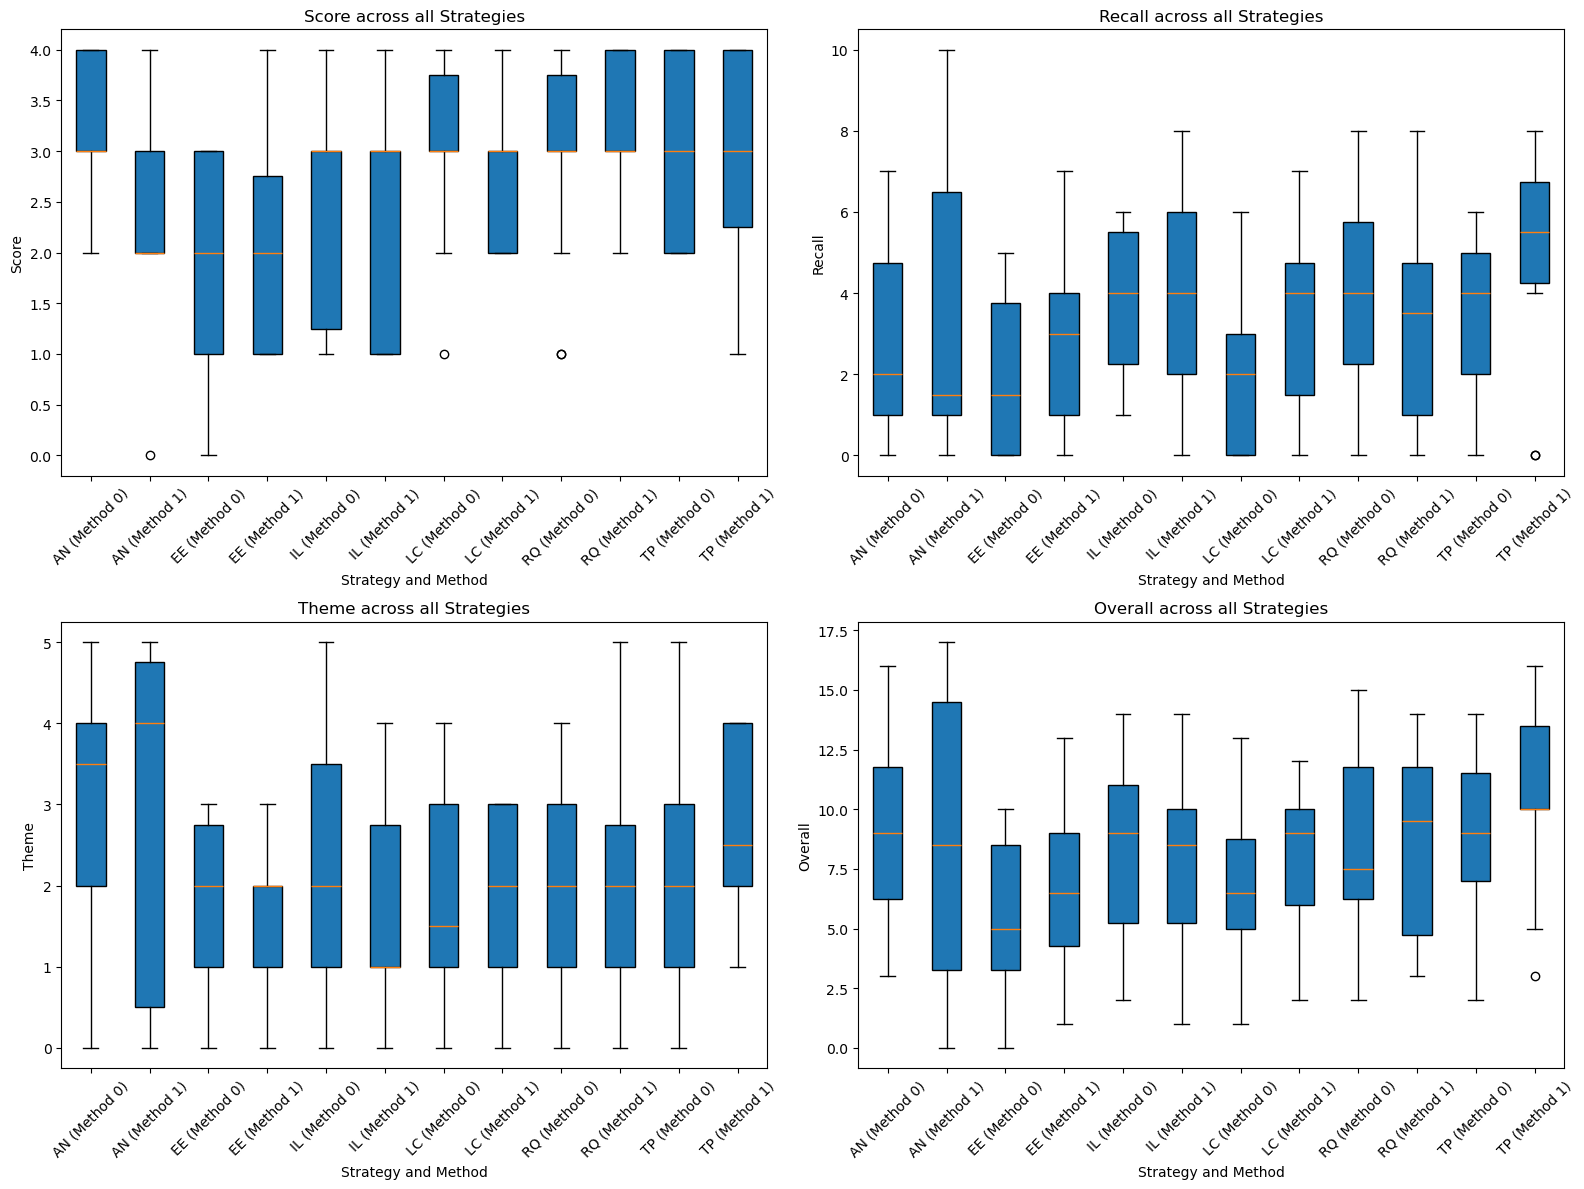

{
    "score": {
        "ANOVA": {
            "sum_sq": {
                "strategy": 32.83333333333327,
                "corpus": 0.09523809523809693,
                "strategy:corpus": 10.190476190476184,
                "method": 0.595238095238092,
                "strategy:method": 6.833333333333331,
                "corpus:method": 1.5238095238095295,
                "strategy:corpus:method": 7.337053779626846,
                "participant": 0.004105928085522487,
                "Residual": 125.99589407191452
            },
            "df": {
                "strategy": 5.0,
                "corpus": 1.0,
                "strategy:corpus": 5.0,
                "method": 1.0,
                "strategy:method": 5.0,
                "corpus:method": 1.0,
                "strategy:corpus:method": 5.0,
                "participant": 1.0,
                "Residual": 143.0
            },
            "F": {
                "strategy": 7.452888367912694,
                "corpus": 0.1080

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
import json

# Load the uploaded data
file_path = 'questionnaire/long_term/response_summary_long.csv'
data = pd.read_csv(file_path)

# Extract unique strategies
strategies = data['strategy'].unique()

# Initialize dictionary to store ANOVA results and means of method 0 and method 1
results = {}

# Prepare subplots for combined visualization
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
columns = ['score', 'recall', 'theme', 'overall']
axes = axs.flatten()

# Iterate over each column of interest
for i, column in enumerate(columns):
    combined_data = []
    labels = []
    
    results[column] = {}
    
    # Fit the repeated measures ANOVA model for each measure (score, recall, theme, overall)
    model = ols(f'{column} ~ strategy * corpus * method + participant', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Store ANOVA results in the dictionary
    results[column]['ANOVA'] = anova_table.to_dict()

    for strategy in strategies:
        strategy_data = data[data['strategy'] == strategy]
        
        method_0_data = strategy_data[strategy_data['method'] == 0][column].values
        method_1_data = strategy_data[strategy_data['method'] == 1][column].values
        
        # Calculate means for method 0 and method 1
        mean_0 = method_0_data.mean()
        mean_1 = method_1_data.mean()
        
        # Store both means in the results dictionary
        results[column][strategy] = {
            'method_0_mean': mean_0,
            'method_1_mean': mean_1,
        }
        
        # Combine data for boxplot
        combined_data.append(method_0_data)
        combined_data.append(method_1_data)
        labels.append(f'{strategy} (Method 0)')
        labels.append(f'{strategy} (Method 1)')
    
    # Plotting combined boxplot for each column
    axes[i].boxplot(combined_data, labels=labels, patch_artist=True)
    axes[i].set_title(f'{column.capitalize()} across all Strategies')
    axes[i].set_xlabel('Strategy and Method')
    axes[i].set_ylabel(column.capitalize())
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display the combined results dictionary with means and ANOVA results
print(json.dumps(results, indent=4))


## Topic‘s influence 

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 假设数据已加载
file_path = 'questionnaire/long_term/response_summary_long.csv'  # 替换为您的文件路径
data = pd.read_csv(file_path)

# 要分析的四个维度
dimensions = ['score', 'recall', 'theme', 'overall']

# 循环分析每个维度
for dimension in dimensions:
    print(f"\nAnalysis for {dimension}:")

    # 创建线性回归模型，评估 topic 的影响
    model = ols(f'{dimension} ~ topic', data=data).fit()
    
    # 生成 ANOVA 表
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA results for {dimension}:")
    print(anova_table)

    # 执行 Tukey HSD 测试，进一步分析 topic 的影响
    print(f"\nTukey HSD results for {dimension}:")
    tukey = pairwise_tukeyhsd(endog=data[dimension], groups=data['topic'], alpha=0.05)
    print(tukey)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# 假设数据已加载
file_path = 'questionnaire/long_term/response_summary_long.csv'  # 替换为您的文件路径
data = pd.read_csv(file_path)

# 过滤数据只保留 method = 0 的情况
method_0_data = data[data['method'] == 0]

# 要分析的四个维度
dimensions = ['score', 'recall', 'theme', 'overall']

# 循环遍历每个维度并执行 Tukey HSD 测试
for dimension in dimensions:
    print(f"\nTukey HSD results for {dimension} (Method = 0):")
    tukey = pairwise_tukeyhsd(endog=method_0_data[dimension], groups=method_0_data['topic'], alpha=0.05)
    print(tukey)


# Topic=0 or Topic=1' tukey

In [15]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# 加载数据
file_path = 'questionnaire/long_term/response_summary_long.csv'  # 替换为您的文件路径
data = pd.read_csv(file_path)

# 要分析的四个维度
dimensions = ['score', 'recall', 'theme', 'overall']

# 分别针对 method=0 和 method=1 进行分析
methods = [0, 1]

for method in methods:
    print(f"\nTukey HSD analysis for method={method}:")

    # 过滤数据只保留当前 method 的情况
    method_data = data[data['method'] == method]
    
    for dimension in dimensions:
        print(f"\nTukey HSD results for {dimension} (Method = {method}):")
        tukey = pairwise_tukeyhsd(endog=method_data[dimension], groups=method_data['topic'], alpha=0.05)
        print(tukey.summary())



Tukey HSD analysis for method=0:

Tukey HSD results for score (Method = 0):
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  AN_G   AN_O  -0.1429    1.0 -1.8451  1.5594  False
  AN_G   EE_G     -1.0 0.7021 -2.7023  0.7023  False
  AN_G   EE_O  -2.2857 0.0013  -3.988 -0.5835   True
  AN_G   IL_G  -1.1429 0.5082 -2.8451  0.5594  False
  AN_G   IL_O  -0.7143 0.9562 -2.4165   0.988  False
  AN_G   LC_G  -0.8571 0.8619 -2.5594  0.8451  False
  AN_G   LC_O   0.1429    1.0 -1.5594  1.8451  False
  AN_G   RQ_G  -0.4286 0.9994 -2.1308  1.2737  False
  AN_G   RQ_O  -0.5714  0.992 -2.2737  1.1308  False
  AN_G   TP_G      0.0    1.0 -1.7023  1.7023  False
  AN_G   TP_O  -0.7143 0.9562 -2.4165   0.988  False
  AN_O   EE_G  -0.8571 0.8619 -2.5594  0.8451  False
  AN_O   EE_O  -2.1429 0.0034 -3.8451 -0.4406   True
  AN_O   IL_G     -1.0 0.7021 -2.7023  0.7023  False
  AN_O   IL_O  -0.5714

## Short term results 

In [ ]:
import pandas as pd
from scipy.stats import ttest_rel

# Step 1: Load the data and split by method
df = pd.read_csv('questionnaire/short_term/response_summary.csv')  # Replace with your CSV file path

# Split into two dataframes based on method
df_method_0 = df[df['method'] == 0]
df_method_1 = df[df['method'] == 1]

# Function to compute baseline scores
def compute_baseline(df_method_0, column_name):
    baseline_scores = df_method_0.groupby(['participant', 'corpus'])[column_name].mean().reset_index()
    baseline_scores.rename(columns={column_name: f'baseline_{column_name}'}, inplace=True)
    return baseline_scores

# List of columns to perform t-tests on
columns_to_test = [
    'score', 'competence', 'activity', 'frustration', 'pleasure', 'pressure', 
    'effort', 'immersion', 'physicality', 'difficulty', 'familarity', 'understanding'
]

# Initialize a list to store the results
results = []

# Function to perform t-test and store results by corpus
def perform_t_test_by_corpus(df_method_1_merged, column_name):
    grouped = df_method_1_merged.groupby('corpus')
    for corpus_name, group in grouped:
        t_stat, p_value = ttest_rel(group[column_name], group[f'baseline_{column_name}'])
        average_score_method_0 = df_method_0[df_method_0['corpus'] == corpus_name][column_name].mean()
        average_score_method_1 = group[column_name].mean()
        
        # Store the results in the list
        results.append({
            'corpus': corpus_name,
            'metric': column_name,
            'average_method_0': average_score_method_0,
            'average_method_1': average_score_method_1,
            't_statistic': t_stat,
            'p_value': p_value
        })

# Perform t-tests for each column grouped by corpus
for column in columns_to_test:
    # Compute baseline scores for the current column
    baseline_score = compute_baseline(df_method_0, column)
    
    # Merge the baseline scores with method==1 dataframe
    df_method_1_merged = pd.merge(df_method_1, baseline_score, on=['participant', 'corpus'])
    
    # Perform t-test for the current column grouped by corpus
    perform_t_test_by_corpus(df_method_1_merged, column)

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Output the results DataFrame
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('questionnaire/short_term/t-test_results_all_columns.csv', index=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import json

# 读取CSV数据到DataFrame
data = pd.read_csv('questionnaire/short_term/t-test_results.csv')

# 提取感兴趣的列
columns_of_interest = [
   'score', 'competence', 'activity', 'frustration', 'pleasure', 'pressure', 
    'effort', 'immersion', 'physicality', 'difficulty', 'familarity', 'understanding'
]

# 提取各策略的唯一值
strategies = data['strategy'].unique()
results = {}

# 对每个感兴趣的列进行迭代
for column in columns_of_interest:
    boxplot_data = []
    labels = []
    results[column] = {}
    
    for strategy in strategies:
        strategy_data = data[data['strategy'] == strategy]
        
        # 提取基准数据和策略数据
        baseline_data = strategy_data['baseline_' + column].values
        strategy_data_values = strategy_data[column].values
        
        # 计算均值
        baseline_mean = baseline_data.mean()
        strategy_mean = strategy_data_values.mean()
        
        # 进行配对t检验以获得p值
        t_stat, p_value = stats.ttest_rel(baseline_data, strategy_data_values)
        
        # 将结果存储到字典中
        results[column][strategy] = {
            'baseline_mean': baseline_mean,
            'strategy_mean': strategy_mean,
            'p_value': p_value
        }
        
        # 为箱线图准备数据
        boxplot_data.append(baseline_data)
        boxplot_data.append(strategy_data_values)
        labels.append(f'{strategy} baseline')
        labels.append(f'{strategy} w/ strategy')
    
    # 绘图
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.boxplot(boxplot_data, labels=labels, patch_artist=True)

    plt.xlabel('Strategy')
    plt.ylabel(column.capitalize())
    plt.title(f'{column.capitalize()} of Baseline vs. Strategy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 可选：将结果保存到JSON文件
with open('strategy_results.json', 'w') as json_file:
    json.dump(results, json_file, indent=4)

# 打印结果字典以供查看
print(json.dumps(results, indent=4))
